# Compas Data Imputation Analysis

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils.data import create_compas_dataset, Dataset
from utils.generator import gen_complete_random
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row

In [4]:
data = create_compas_dataset()

In [5]:
data_compas_complete = data.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()

In [6]:
X = data_compas_complete.X.drop(columns=data_compas_complete.protected).copy().to_numpy()
y = data_compas_complete.y.copy()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [8]:
from imblearn.over_sampling import SVMSMOTE

### Parameter Searching

In [9]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, model, params, smote):
    print("Model: {}".format(model.__class__.__name__))
    X_res, y_res = smote.fit_resample(X, y) # enlarge dataset
    search = GridSearchCV(model, param_grid=params, cv=10, n_jobs=-1)
    search.fit(X_res, y_res)
    print("Best parameter: {}".format(search.best_params_))
    print("Acc best: {:.4f}".format(search.best_score_))
    print("Acc on input data: {:.4f}".format(search.best_estimator_.score(X, y)))
    print("Acc on enlarged data: {:.4f}".format(search.best_estimator_.score(X_res, y_res)))
    return search.best_params_

In [10]:
all_params = {
    "KNN": None,
    "LinearSVC": None,
    "SVC": None,
    "Forest": None,
    "LogReg": None,
    "Tree": None,
    "MLP": None,
}

In [11]:
tmp_params = {
    "n_neighbors": [2, 5, 10, 50, 100, 500],
    "leaf_size": [5, 10, 30, 50, 100],
}
all_params["KNN"] = grid_search(X, y, KNeighborsClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'leaf_size': 5, 'n_neighbors': 2}
Acc best: 0.7061
Acc on input data: 0.8993
Acc on enlarged data: 0.9071


In [12]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000],
}
all_params["LinearSVC"] = grid_search(X, y, LinearSVC(dual=False), tmp_params, SVMSMOTE(random_state=22))

Model: LinearSVC
Best parameter: {'C': 0.1, 'max_iter': 1000, 'tol': 0.001}
Acc best: 0.6728
Acc on input data: 0.6641
Acc on enlarged data: 0.6725


In [13]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000, -1],
}
all_params["SVC"] = grid_search(X, y, SVC(), tmp_params, SVMSMOTE(random_state=22))

Model: SVC
Best parameter: {'C': 10, 'max_iter': -1, 'tol': 0.0001}
Acc best: 0.6452
Acc on input data: 0.6285
Acc on enlarged data: 0.6489


In [14]:
tmp_params = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 50, 100],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Forest"] = grid_search(X, y, RandomForestClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: RandomForestClassifier
Best parameter: {'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Acc best: 0.7677
Acc on input data: 0.8166
Acc on enlarged data: 0.8567


In [15]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [1e-2, 1e-1, 1, 1e1, 1e2],
    "max_iter": [100, 500, 1000, 2000],
}
all_params["LogReg"] = grid_search(X, y, LogisticRegression(), tmp_params, SVMSMOTE(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 10.0, 'max_iter': 100, 'tol': 1e-05}
Acc best: 0.6755
Acc on input data: 0.6767
Acc on enlarged data: 0.6762


In [16]:
tmp_params = {
    "max_depth": [None, 10, 50, 100, 200],
    "max_leaf_nodes": [None, 10, 100, 1000],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Tree"] = grid_search(X, y, DecisionTreeClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: DecisionTreeClassifier
Best parameter: {'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 1}
Acc best: 0.7494
Acc on input data: 0.7267
Acc on enlarged data: 0.7765


In [17]:
tmp_params = {
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [1e-4, 1e-3, 1e-2],
    "max_iter": [200, 500, 1000],
}
all_params["MLP"] = grid_search(X, y, MLPClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: MLPClassifier
Best parameter: {'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 500}
Acc best: 0.6878
Acc on input data: 0.6685
Acc on enlarged data: 0.6911


### Data Imputation

In [18]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def bias1(data):
    # input should be data from compute_confusion_matrix
    # bias 1 = (FP_AA / FN_AA) - (FP_C / FN_C)
    FP_AA = data["African-American"][1]
    FN_AA = data["African-American"][2]
    FP_C = data["Caucasian"][1]
    FN_C = data["Caucasian"][2]
    bias = (FP_AA / FN_AA) - (FP_C / FN_C)
    return bias
   
def bias2(data):
    # input should be data from compute_confusion_matrix
    # bias 2 = (FP_AA / FP_C) - (FN_AA / FN_C)
    FP_AA = data["African-American"][1]
    FN_AA = data["African-American"][2]
    FP_C = data["Caucasian"][1]
    FN_C = data["Caucasian"][2]
    bias = (FP_AA / FP_C) - (FN_AA / FN_C)
    return bias

def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

def average_cv(cv_data):
    # compute average for the confusion matrix data for each fold
    result = {}
    for name, data in cv_data.items():
        new_data = {
            "African-American": np.array([m["African-American"] for m in data]).mean(axis=0).tolist(),
            "Caucasian": np.array([m["Caucasian"] for m in data]).mean(axis=0).tolist()
        }
        result[name] = new_data
    return result

def compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=False):
    # X are pandas dataframe
    # y are numpy array
    # clf is a sklearn classifier
    # protected_features is list
    smote = SVMSMOTE(random_state=22)
    if not multi:
        X_train = X_train.drop(columns=protected_features).copy().to_numpy()
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        clf.fit(X_train_res, y_train_res)
        print("Acc: {:.4f}".format(clf.score(X_test.drop(columns=protected_features).copy().to_numpy(), y_test)), end=" ")
        X_test_AA = X_test[X_test["race"] == "African-American"].drop(columns=protected_features).to_numpy()
        X_test_C = X_test[X_test["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
        y_test_AA = y_test[X_test[X_test["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test[X_test["race"] == "Caucasian"].index.tolist()]
        matrix_AA = confusion_matrix(y_test_AA, clf.predict(X_test_AA))
        matrix_C = confusion_matrix(y_test_C, clf.predict(X_test_C))
    else:
        prediction_AA = []
        prediction_C = []
        X_test_first = X_test[0]
        y_test_AA = y_test[X_test_first[X_test_first["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test_first[X_test_first["race"] == "Caucasian"].index.tolist()]
        scores = [0, 0]
        for X_train_m in X_train:
            X_train_m = X_train_m.drop(columns=protected_features).copy().to_numpy()
            X_train_res, y_train_res = smote.fit_resample(X_train_m, y_train)
            clf.fit(X_train_res, y_train_res)
            for X_test_m in X_test:
                X_test_AA = X_test_m[X_test_m["race"] == "African-American"].drop(columns=protected_features).to_numpy()
                X_test_C = X_test_m[X_test_m["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
                prediction_AA.append(clf.predict(X_test_AA))
                prediction_C.append(clf.predict(X_test_C))
                scores[0] += clf.score(X_test_m.drop(columns=protected_features).copy().to_numpy(), y_test)
                scores[1] += 1
        print("Acc: {:.4f}".format(scores[0] / scores[1]), end=" ")
        # compute final predictions by voting
        prediction_AA = np.apply_along_axis(helper_freq, 0, np.array(prediction_AA))
        prediction_C = np.apply_along_axis(helper_freq, 0, np.array(prediction_C))
        matrix_AA = confusion_matrix(y_test_AA, prediction_AA)
        matrix_C = confusion_matrix(y_test_C, prediction_C)
    result = {
        "African-American": matrix_AA.ravel().tolist(), # [tn, fp, fn, tp]
        "Caucasian": matrix_C.ravel().tolist()
    }
    return result

def test_imputation(X, y, protected_features, completer_func=None, multi=False):
    # X is pandas dataframe
    # y is numpy array,
    # protected_features is list
    # completer func is the imputation function
    global all_params
    clfs = { # define all the classifiers with best parameters
        "KNN": KNeighborsClassifier(n_neighbors=all_params["KNN"]["n_neighbors"], leaf_size=all_params["KNN"]["leaf_size"]),
        "LinearSVC": LinearSVC(dual=False, tol=all_params["LinearSVC"]["tol"], C=all_params["LinearSVC"]["C"], max_iter=all_params["LinearSVC"]["max_iter"]),
        "SVC": SVC(tol=all_params["SVC"]["tol"], C=all_params["SVC"]["C"], max_iter=all_params["SVC"]["max_iter"]),
        "Forest": RandomForestClassifier(n_estimators=all_params["Forest"]["n_estimators"], max_depth=all_params["Forest"]["max_depth"], min_samples_leaf=all_params["Forest"]["min_samples_leaf"]),
        "LogReg": LogisticRegression(tol=all_params["LogReg"]["tol"], C=all_params["LogReg"]["C"], max_iter=all_params["LogReg"]["max_iter"]),
        "Tree": DecisionTreeClassifier(max_depth=all_params["Tree"]["max_depth"], max_leaf_nodes=all_params["Tree"]["max_leaf_nodes"], min_samples_leaf=all_params["Tree"]["min_samples_leaf"]),
        "MLP": MLPClassifier(alpha=all_params["MLP"]["alpha"], learning_rate_init=all_params["MLP"]["learning_rate_init"], max_iter=all_params["MLP"]["max_iter"]),
    }
    data_cv = { # save each cv output
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias1_cv = { # save each bias 1 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias2_cv = { # save each bias 2 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    kf = KFold(n_splits=10, shuffle=True)
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print("Fold {:>2}".format(fold), end=" ")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_test = X_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        if completer_func:
        # do imputations on training set and test set individually
            data_incomplete = Dataset("tmp", X_train, y_train, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_train = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy() 
            y_train = data_complete[0].y.copy() if multi else data_complete.y.copy()
            data_incomplete = Dataset("tmp", X_test, y_test, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_test = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy()
            y_test = data_complete[0].y.copy() if multi else data_complete.y.copy()
        # get result for each classifier
        for clf_name, clf in clfs.items():
            print("{}".format(clf_name), end=" ")
            result = compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=multi)
            data_cv[clf_name].append(result)
            bias1_cv[clf_name].append(bias1(result))
            bias2_cv[clf_name].append(bias2(result))
        print()
        fold += 1
    # print("Result:\n{}".format(data_cv))
    return (data_cv, bias1_cv, bias2_cv)

In [19]:
# try on original data
result_original = test_imputation(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

Fold  1 KNN Acc: 0.6507 LinearSVC Acc: 0.6677 SVC Acc: 0.6038 Forest Acc: 0.7071 LogReg Acc: 0.6763 Tree Acc: 0.6933 MLP Acc: 0.6645 
Fold  2 KNN Acc: 0.6198 LinearSVC Acc: 0.6496 SVC Acc: 0.5985 Forest Acc: 0.7135 LogReg Acc: 0.6784 Tree Acc: 0.6794 MLP Acc: 0.6805 
Fold  3 KNN Acc: 0.6486 LinearSVC Acc: 0.6709 SVC Acc: 0.6230 Forest Acc: 0.7167 LogReg Acc: 0.6826 Tree Acc: 0.7082 MLP Acc: 0.6294 
Fold  4 KNN Acc: 0.6613 LinearSVC Acc: 0.6880 SVC Acc: 0.6390 Forest Acc: 0.7071 LogReg Acc: 0.7007 Tree Acc: 0.7018 MLP Acc: 0.6539 
Fold  5 KNN Acc: 0.6237 LinearSVC Acc: 0.6716 SVC Acc: 0.6002 Forest Acc: 0.6994 LogReg Acc: 0.6834 Tree Acc: 0.6962 MLP Acc: 0.6290 
Fold  6 KNN Acc: 0.6311 LinearSVC Acc: 0.6599 SVC Acc: 0.5970 Forest Acc: 0.7111 LogReg Acc: 0.6567 Tree Acc: 0.6791 MLP Acc: 0.6279 
Fold  7 KNN Acc: 0.6514 LinearSVC Acc: 0.6706 SVC Acc: 0.6109 Forest Acc: 0.7122 LogReg Acc: 0.6695 Tree Acc: 0.6855 MLP Acc: 0.6823 
Fold  8 KNN Acc: 0.6258 LinearSVC Acc: 0.6588 SVC Acc: 0.5896 

### 20% Random

In [20]:
# generate simulated missing data
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.2)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 20980 NaN values have been inserted


age                        1767
age_cat                    1765
c_charge_degree            1726
priors_count               1735
juv_misd_count             1766
juv_fel_count              1716
juv_other_count            1723
c_charge_desc              1721
days_b_screening_arrest    1767
sex                        1740
race                       1775
length_of_stay             1779
dtype: int64

In [21]:
# fill by mean on simulated
result_mean_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6305 LinearSVC Acc: 0.6518 SVC Acc: 0.5634 Forest Acc: 0.5612 LogReg Acc: 0.6709 Tree Acc: 0.6177 MLP Acc: 0.6635 
Fold  2 KNN Acc: 0.6070 LinearSVC Acc: 0.6411 SVC Acc: 0.5836 Forest Acc: 0.5463 LogReg Acc: 0.6464 Tree Acc: 0.5964 MLP Acc: 0.6539 
Fold  3 KNN Acc: 0.6219 LinearSVC Acc: 0.6613 SVC Acc: 0.5889 Forest Acc: 0.5676 LogReg Acc: 0.6635 Tree Acc: 0.6145 MLP Acc: 0.6699 
Fold  4 KNN Acc: 0.6454 LinearSVC Acc: 0.6411 SVC Acc: 0.5740 Forest Acc: 0.5676 LogReg Acc: 0.6443 Tree Acc: 0.5985 MLP Acc: 0.5932 
Fold  5 KNN Acc: 0.6013 LinearSVC Acc: 0.6066 SVC Acc: 0.5469 Forest Acc: 0.5928 LogReg Acc: 0.6311 Tree Acc: 0.6183 MLP Acc: 0.6173 
Fold  6 KNN Acc: 0.5970 LinearSVC Acc: 0.6610 SVC Acc: 0.5490 Forest Acc: 0.5917 LogReg Acc: 0.6599 Tree Acc: 0.5896 MLP Acc: 0.6407 
Fold  7 KNN Acc: 0.6279 LinearSVC Acc: 0.6471 SVC Acc: 0.5714 Forest Acc: 0.5597 LogReg Acc: 0.6386 Tree Acc: 0.5981 MLP Acc: 0.6013 
Fold  8 KNN Acc: 0.6482 LinearSVC Acc: 0.6684 SVC Acc: 0.5874 

In [22]:
# fill by similar on simulated
result_similar_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6038 LinearSVC Acc: 0.6326 SVC Acc: 0.5580 Forest Acc: 0.6326 LogReg Acc: 0.6262 Tree Acc: 0.6251 MLP Acc: 0.5740 
Fold  2 KNN Acc: 0.6315 LinearSVC Acc: 0.6347 SVC Acc: 0.5847 Forest Acc: 0.6592 LogReg Acc: 0.6507 Tree Acc: 0.6624 MLP Acc: 0.5559 
Fold  3 KNN Acc: 0.6368 LinearSVC Acc: 0.6550 SVC Acc: 0.6028 Forest Acc: 0.6784 LogReg Acc: 0.6603 Tree Acc: 0.6518 MLP Acc: 0.5868 
Fold  4 KNN Acc: 0.6635 LinearSVC Acc: 0.6624 SVC Acc: 0.5644 Forest Acc: 0.6901 LogReg Acc: 0.6752 Tree Acc: 0.6848 MLP Acc: 0.6283 
Fold  5 KNN Acc: 0.6215 LinearSVC Acc: 0.6215 SVC Acc: 0.5917 Forest Acc: 0.6642 LogReg Acc: 0.6269 Tree Acc: 0.6514 MLP Acc: 0.6663 
Fold  6 KNN Acc: 0.6002 LinearSVC Acc: 0.6546 SVC Acc: 0.5746 Forest Acc: 0.6535 LogReg Acc: 0.6386 Tree Acc: 0.6311 MLP Acc: 0.6333 
Fold  7 KNN Acc: 0.6034 LinearSVC Acc: 0.6738 SVC Acc: 0.6151 Forest Acc: 0.6866 LogReg Acc: 0.6770 Tree Acc: 0.6461 MLP Acc: 0.6631 
Fold  8 KNN Acc: 0.6237 LinearSVC Acc: 0.6525 SVC Acc: 0.5704 

In [23]:
# fill by multiple imputation on simulated
result_multi_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6165 LinearSVC Acc: 0.6275 SVC Acc: 0.6082 Forest Acc: 0.6401 LogReg Acc: 0.6317 Tree Acc: 0.6276 MLP Acc: 0.6430 
Fold  2 KNN Acc: 0.6192 LinearSVC Acc: 0.6217 SVC Acc: 0.5729 Forest Acc: 0.6296 LogReg Acc: 0.6288 Tree Acc: 0.6093 MLP Acc: 0.6263 
Fold  3 KNN Acc: 0.6355 LinearSVC Acc: 0.6545 SVC Acc: 0.5890 Forest Acc: 0.6676 LogReg Acc: 0.6572 Tree Acc: 0.6463 MLP Acc: 0.6436 
Fold  4 KNN Acc: 0.6239 LinearSVC Acc: 0.6600 SVC Acc: 0.5914 Forest Acc: 0.6634 LogReg Acc: 0.6620 Tree Acc: 0.6418 MLP Acc: 0.6457 
Fold  5 KNN Acc: 0.6264 LinearSVC Acc: 0.6374 SVC Acc: 0.5760 Forest Acc: 0.6380 LogReg Acc: 0.6401 Tree Acc: 0.6207 MLP Acc: 0.6089 
Fold  6 KNN Acc: 0.6179 LinearSVC Acc: 0.6226 SVC Acc: 0.5423 Forest Acc: 0.6627 LogReg Acc: 0.6293 Tree Acc: 0.6460 MLP Acc: 0.6127 
Fold  7 KNN Acc: 0.6131 LinearSVC Acc: 0.6239 SVC Acc: 0.5472 Forest Acc: 0.6520 LogReg Acc: 0.6352 Tree Acc: 0.6310 MLP Acc: 0.6140 
Fold  8 KNN Acc: 0.6088 LinearSVC Acc: 0.6582 SVC Acc: 0.5732 

### 10% Random

In [24]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.1)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 8901 NaN values have been inserted


age                        739
age_cat                    785
c_charge_degree            728
priors_count               736
juv_misd_count             719
juv_fel_count              732
juv_other_count            745
c_charge_desc              710
days_b_screening_arrest    767
sex                        733
race                       765
length_of_stay             742
dtype: int64

In [25]:
# fill by mean on simulated
result_mean_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6337 LinearSVC Acc: 0.6432 SVC Acc: 0.5644 Forest Acc: 0.6273 LogReg Acc: 0.6624 Tree Acc: 0.6443 MLP Acc: 0.6368 
Fold  2 KNN Acc: 0.6315 LinearSVC Acc: 0.6677 SVC Acc: 0.5815 Forest Acc: 0.6784 LogReg Acc: 0.6773 Tree Acc: 0.6677 MLP Acc: 0.6124 
Fold  3 KNN Acc: 0.6422 LinearSVC Acc: 0.6731 SVC Acc: 0.5836 Forest Acc: 0.6539 LogReg Acc: 0.6773 Tree Acc: 0.6741 MLP Acc: 0.6550 
Fold  4 KNN Acc: 0.6155 LinearSVC Acc: 0.6581 SVC Acc: 0.6113 Forest Acc: 0.6592 LogReg Acc: 0.6560 Tree Acc: 0.6581 MLP Acc: 0.6635 
Fold  5 KNN Acc: 0.6429 LinearSVC Acc: 0.6482 SVC Acc: 0.5885 Forest Acc: 0.6695 LogReg Acc: 0.6716 Tree Acc: 0.6557 MLP Acc: 0.6311 
Fold  6 KNN Acc: 0.6141 LinearSVC Acc: 0.6663 SVC Acc: 0.5991 Forest Acc: 0.6407 LogReg Acc: 0.6748 Tree Acc: 0.6567 MLP Acc: 0.6333 
Fold  7 KNN Acc: 0.6482 LinearSVC Acc: 0.6652 SVC Acc: 0.6023 Forest Acc: 0.6546 LogReg Acc: 0.6706 Tree Acc: 0.6514 MLP Acc: 0.5842 
Fold  8 KNN Acc: 0.6258 LinearSVC Acc: 0.6439 SVC Acc: 0.5842 

In [26]:
# fill by similar on simulated
result_similar_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6475 LinearSVC Acc: 0.6518 SVC Acc: 0.5815 Forest Acc: 0.6976 LogReg Acc: 0.6720 Tree Acc: 0.6826 MLP Acc: 0.6177 
Fold  2 KNN Acc: 0.6294 LinearSVC Acc: 0.6635 SVC Acc: 0.5708 Forest Acc: 0.6869 LogReg Acc: 0.6571 Tree Acc: 0.6794 MLP Acc: 0.6624 
Fold  3 KNN Acc: 0.6113 LinearSVC Acc: 0.6773 SVC Acc: 0.6155 Forest Acc: 0.6944 LogReg Acc: 0.6741 Tree Acc: 0.6731 MLP Acc: 0.6773 
Fold  4 KNN Acc: 0.6432 LinearSVC Acc: 0.6400 SVC Acc: 0.5921 Forest Acc: 0.6539 LogReg Acc: 0.6539 Tree Acc: 0.6315 MLP Acc: 0.6475 
Fold  5 KNN Acc: 0.6375 LinearSVC Acc: 0.6599 SVC Acc: 0.6055 Forest Acc: 0.6588 LogReg Acc: 0.6791 Tree Acc: 0.6439 MLP Acc: 0.6461 
Fold  6 KNN Acc: 0.6343 LinearSVC Acc: 0.6727 SVC Acc: 0.6055 Forest Acc: 0.6770 LogReg Acc: 0.6738 Tree Acc: 0.6599 MLP Acc: 0.6279 
Fold  7 KNN Acc: 0.6173 LinearSVC Acc: 0.6407 SVC Acc: 0.6066 Forest Acc: 0.6567 LogReg Acc: 0.6471 Tree Acc: 0.6823 MLP Acc: 0.6269 
Fold  8 KNN Acc: 0.6525 LinearSVC Acc: 0.6695 SVC Acc: 0.5970 

In [27]:
# fill by multiple imputation on simulated
result_multi_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6380 LinearSVC Acc: 0.6605 SVC Acc: 0.5986 Forest Acc: 0.6894 LogReg Acc: 0.6659 Tree Acc: 0.6866 MLP Acc: 0.6796 
Fold  2 KNN Acc: 0.6103 LinearSVC Acc: 0.6635 SVC Acc: 0.5849 Forest Acc: 0.6801 LogReg Acc: 0.6618 Tree Acc: 0.6671 MLP Acc: 0.6331 
Fold  3 KNN Acc: 0.6270 LinearSVC Acc: 0.6343 SVC Acc: 0.5628 Forest Acc: 0.6732 LogReg Acc: 0.6369 Tree Acc: 0.6661 MLP Acc: 0.6280 
Fold  4 KNN Acc: 0.6051 LinearSVC Acc: 0.6665 SVC Acc: 0.5946 Forest Acc: 0.6867 LogReg Acc: 0.6690 Tree Acc: 0.6796 MLP Acc: 0.6704 
Fold  5 KNN Acc: 0.6157 LinearSVC Acc: 0.6380 SVC Acc: 0.5546 Forest Acc: 0.6499 LogReg Acc: 0.6466 Tree Acc: 0.6482 MLP Acc: 0.6297 
Fold  6 KNN Acc: 0.6476 LinearSVC Acc: 0.6681 SVC Acc: 0.6099 Forest Acc: 0.6928 LogReg Acc: 0.6759 Tree Acc: 0.6826 MLP Acc: 0.6563 
Fold  7 KNN Acc: 0.6476 LinearSVC Acc: 0.6577 SVC Acc: 0.5616 Forest Acc: 0.6782 LogReg Acc: 0.6594 Tree Acc: 0.6659 MLP Acc: 0.6524 
Fold  8 KNN Acc: 0.6338 LinearSVC Acc: 0.6773 SVC Acc: 0.6022 

### 5% Random

In [28]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.05)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 4196 NaN values have been inserted


age                        330
age_cat                    352
c_charge_degree            364
priors_count               346
juv_misd_count             340
juv_fel_count              363
juv_other_count            360
c_charge_desc              336
days_b_screening_arrest    338
sex                        354
race                       355
length_of_stay             358
dtype: int64

In [29]:
# fill by mean on simulated
result_mean_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6326 LinearSVC Acc: 0.6539 SVC Acc: 0.6177 Forest Acc: 0.6954 LogReg Acc: 0.6720 Tree Acc: 0.6922 MLP Acc: 0.6550 
Fold  2 KNN Acc: 0.6400 LinearSVC Acc: 0.6411 SVC Acc: 0.6006 Forest Acc: 0.6645 LogReg Acc: 0.6518 Tree Acc: 0.6507 MLP Acc: 0.5708 
Fold  3 KNN Acc: 0.6198 LinearSVC Acc: 0.6816 SVC Acc: 0.5772 Forest Acc: 0.6997 LogReg Acc: 0.6933 Tree Acc: 0.6922 MLP Acc: 0.6805 
Fold  4 KNN Acc: 0.6368 LinearSVC Acc: 0.6826 SVC Acc: 0.6347 Forest Acc: 0.6763 LogReg Acc: 0.6997 Tree Acc: 0.6592 MLP Acc: 0.6560 
Fold  5 KNN Acc: 0.6215 LinearSVC Acc: 0.6599 SVC Acc: 0.5938 Forest Acc: 0.6908 LogReg Acc: 0.6578 Tree Acc: 0.6684 MLP Acc: 0.6226 
Fold  6 KNN Acc: 0.6087 LinearSVC Acc: 0.6770 SVC Acc: 0.6141 Forest Acc: 0.6908 LogReg Acc: 0.6706 Tree Acc: 0.6748 MLP Acc: 0.6354 
Fold  7 KNN Acc: 0.6194 LinearSVC Acc: 0.6461 SVC Acc: 0.5714 Forest Acc: 0.6855 LogReg Acc: 0.6578 Tree Acc: 0.6599 MLP Acc: 0.6322 
Fold  8 KNN Acc: 0.6322 LinearSVC Acc: 0.6567 SVC Acc: 0.6087 

In [30]:
# fill by similar on simulated
result_similar_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6411 LinearSVC Acc: 0.6613 SVC Acc: 0.5921 Forest Acc: 0.7071 LogReg Acc: 0.6699 Tree Acc: 0.6933 MLP Acc: 0.6709 
Fold  2 KNN Acc: 0.6230 LinearSVC Acc: 0.6454 SVC Acc: 0.5942 Forest Acc: 0.6837 LogReg Acc: 0.6613 Tree Acc: 0.6880 MLP Acc: 0.6166 
Fold  3 KNN Acc: 0.6337 LinearSVC Acc: 0.6486 SVC Acc: 0.6155 Forest Acc: 0.6805 LogReg Acc: 0.6635 Tree Acc: 0.6539 MLP Acc: 0.6550 
Fold  4 KNN Acc: 0.6326 LinearSVC Acc: 0.6794 SVC Acc: 0.6070 Forest Acc: 0.7050 LogReg Acc: 0.6731 Tree Acc: 0.6944 MLP Acc: 0.6496 
Fold  5 KNN Acc: 0.6194 LinearSVC Acc: 0.6802 SVC Acc: 0.6173 Forest Acc: 0.6972 LogReg Acc: 0.6898 Tree Acc: 0.6866 MLP Acc: 0.7015 
Fold  6 KNN Acc: 0.6343 LinearSVC Acc: 0.6663 SVC Acc: 0.6205 Forest Acc: 0.6684 LogReg Acc: 0.6716 Tree Acc: 0.6759 MLP Acc: 0.6631 
Fold  7 KNN Acc: 0.6162 LinearSVC Acc: 0.6429 SVC Acc: 0.6013 Forest Acc: 0.6738 LogReg Acc: 0.6567 Tree Acc: 0.6525 MLP Acc: 0.6525 
Fold  8 KNN Acc: 0.6237 LinearSVC Acc: 0.6855 SVC Acc: 0.5768 

In [31]:
# fill by multiple imputation on simulated
result_multi_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6388 LinearSVC Acc: 0.6532 SVC Acc: 0.5942 Forest Acc: 0.6929 LogReg Acc: 0.6622 Tree Acc: 0.6801 MLP Acc: 0.6257 
Fold  2 KNN Acc: 0.6260 LinearSVC Acc: 0.6534 SVC Acc: 0.5888 Forest Acc: 0.6926 LogReg Acc: 0.6629 Tree Acc: 0.6913 MLP Acc: 0.6345 
Fold  3 KNN Acc: 0.6081 LinearSVC Acc: 0.6642 SVC Acc: 0.5918 Forest Acc: 0.6732 LogReg Acc: 0.6657 Tree Acc: 0.6509 MLP Acc: 0.6443 
Fold  4 KNN Acc: 0.6193 LinearSVC Acc: 0.6535 SVC Acc: 0.5781 Forest Acc: 0.6879 LogReg Acc: 0.6683 Tree Acc: 0.6731 MLP Acc: 0.6577 
Fold  5 KNN Acc: 0.6320 LinearSVC Acc: 0.6824 SVC Acc: 0.6202 Forest Acc: 0.7006 LogReg Acc: 0.6904 Tree Acc: 0.6892 MLP Acc: 0.6875 
Fold  6 KNN Acc: 0.6320 LinearSVC Acc: 0.6303 SVC Acc: 0.5644 Forest Acc: 0.6625 LogReg Acc: 0.6409 Tree Acc: 0.6571 MLP Acc: 0.5997 
Fold  7 KNN Acc: 0.6297 LinearSVC Acc: 0.6480 SVC Acc: 0.5739 Forest Acc: 0.6721 LogReg Acc: 0.6538 Tree Acc: 0.6678 MLP Acc: 0.6415 
Fold  8 KNN Acc: 0.6491 LinearSVC Acc: 0.6826 SVC Acc: 0.5951 

### Save Results

In [33]:
# save confusion matrix for each classifier
classifiers = ["KNN", "LinearSVC", "SVC", "Forest", "LogReg", "Tree", "MLP"]
raw_data = [result_original, result_mean_sim_20, result_similar_sim_20, result_multi_sim_20,
            result_mean_sim_10, result_similar_sim_10, result_multi_sim_10,
            result_mean_sim_5, result_similar_sim_5, result_multi_sim_5]
fold_names = ["(Fold {:>2})".format(x+1) for x in range(10)]
conf_names = [x + " " + y for y in fold_names
              for x in ["TN_AA", "FP_AA", "FN_AA", "TP_AA", "TN_C", "FP_C", "FN_C", "TP_C"]]
methods = ["Original",
           "Mean Imputation (20%)",
           "Similar Imputation (20%)",
           "Multiple Imputation (20%)",
           "Mean Imputation (10%)",
           "Similar Imputation (10%)",
           "Multiple Imputation (10%)",
           "Mean Imputation (5%)",
           "Similar Imputation (5%)",
           "Multiple Imputation (5%)"]

if not os.path.exists("compas_analysis"):
    os.makedirs("compas_analysis")

for clf_name in classifiers:
    if not os.path.exists(os.path.join("compas_analysis", clf_name)):
        os.makedirs(os.path.join("compas_analysis", clf_name))    

In [68]:
def save_cv(data):
    data_cv = [m[0] for m in data]
    for clf_name in classifiers:
        new_data = []
        new_data_acc = []
        dd = [m[clf_name] for m in data_cv]
        for fold_10 in dd:
            fold_line = []
            fold_line_acc = []
            for fold in fold_10:
                fold_line += fold["African-American"]
                fold_line += fold["Caucasian"]
                fold_line_acc.append(
                    (fold["African-American"][0] + fold["African-American"][3] +
                     fold["Caucasian"][0] + fold["Caucasian"][3]) /
                    (sum(fold["African-American"]) + sum(fold["Caucasian"]))
                )
            new_data.append(fold_line)
            fold_line_acc.append(sum(fold_line_acc) / len(fold_line_acc))
            new_data_acc.append(fold_line_acc)
        df = pd.DataFrame(new_data, columns=conf_names, index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "10folds.csv"))
        df = pd.DataFrame(new_data_acc, columns=fold_names + ["Average"], index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"))

In [51]:
def save_bias(data):
    bias1 = [m[1] for m in data]
    bias2 = [m[2] for m in data]
    for clf_name in classifiers:
        bias1_clf = [m[clf_name] for m in bias1]
        bias1_clf = [x + [sum(x) / len(x)] for x in bias1_clf]
        bias2_clf = [m[clf_name] for m in bias2]
        bias2_clf = [x + [sum(x) / len(x)] for x in bias2_clf]
        df1 = pd.DataFrame(bias1_clf, columns=fold_names + ["Average"], index=methods)
        df2 = pd.DataFrame(bias2_clf, columns=fold_names + ["Average"], index=methods)
        df1.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"))
        df2.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"))

In [69]:
save_cv(raw_data)
save_bias(raw_data)

### Plots

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

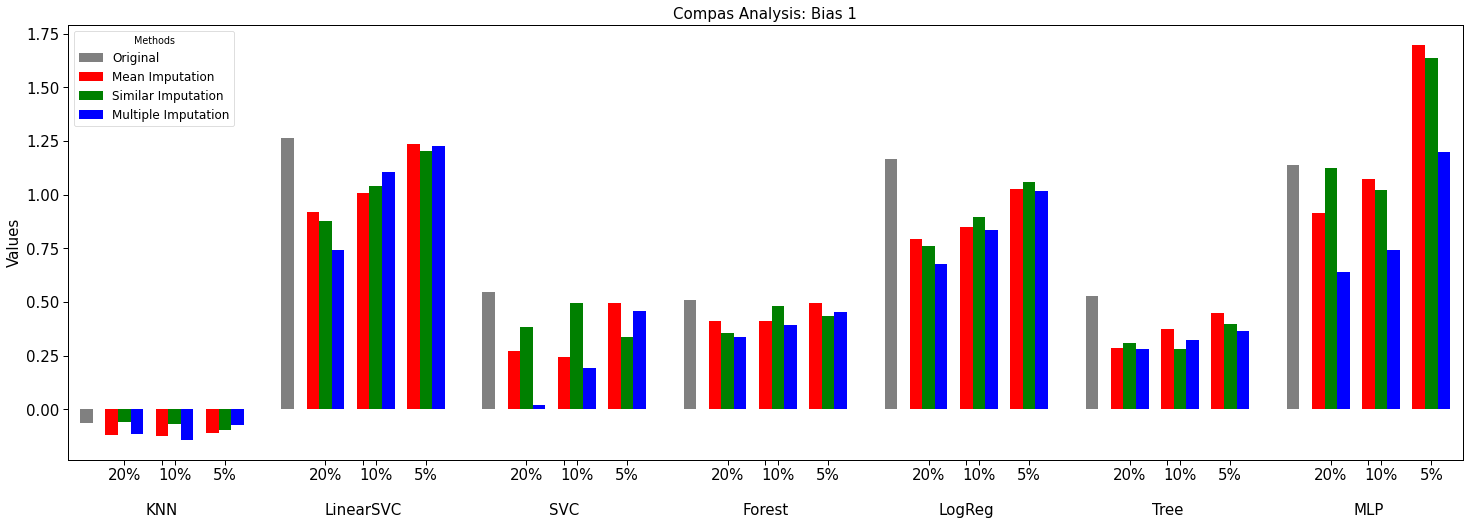

In [111]:
fig = plt.figure(figsize=(25, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=15)
plt.title("Compas Analysis: Bias 1", fontsize=15)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean Imputation", "Similar Imputation", "Multiple Imputation"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
plt.ylabel("Values", fontsize=15)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 12})
plt.savefig("bias1.png", transparent=False)
plt.show()

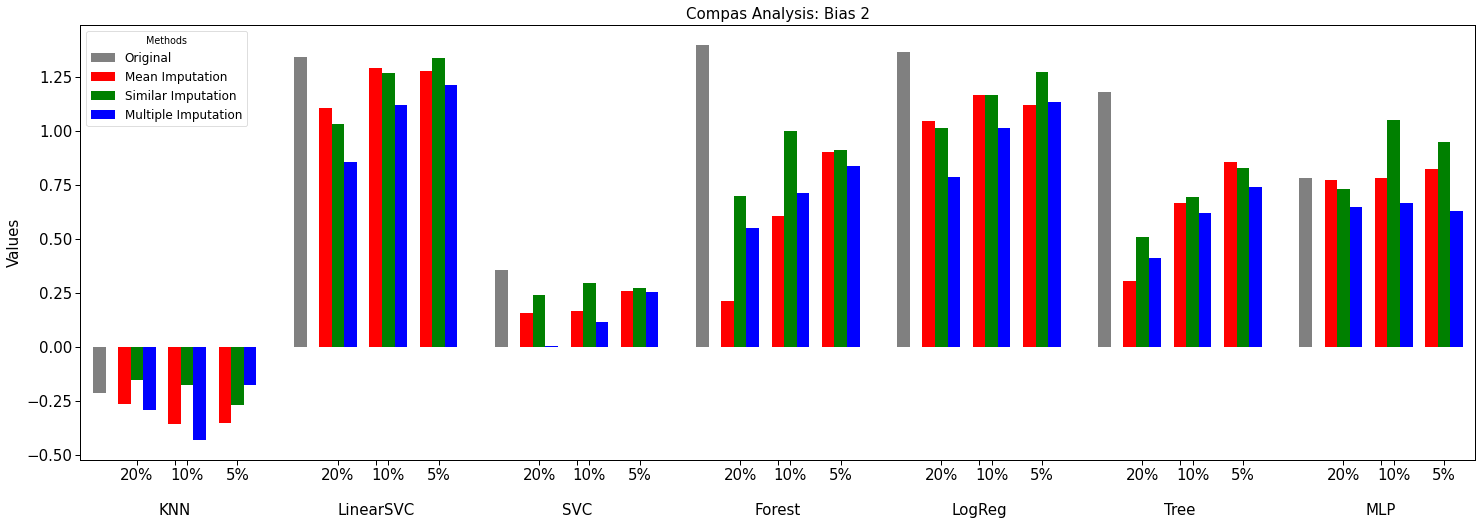

In [110]:
fig = plt.figure(figsize=(25, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=15)
plt.title("Compas Analysis: Bias 2", fontsize=15)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean Imputation", "Similar Imputation", "Multiple Imputation"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
plt.ylabel("Values", fontsize=15)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 12})
plt.savefig("bias2.png", transparent=False)
plt.show()

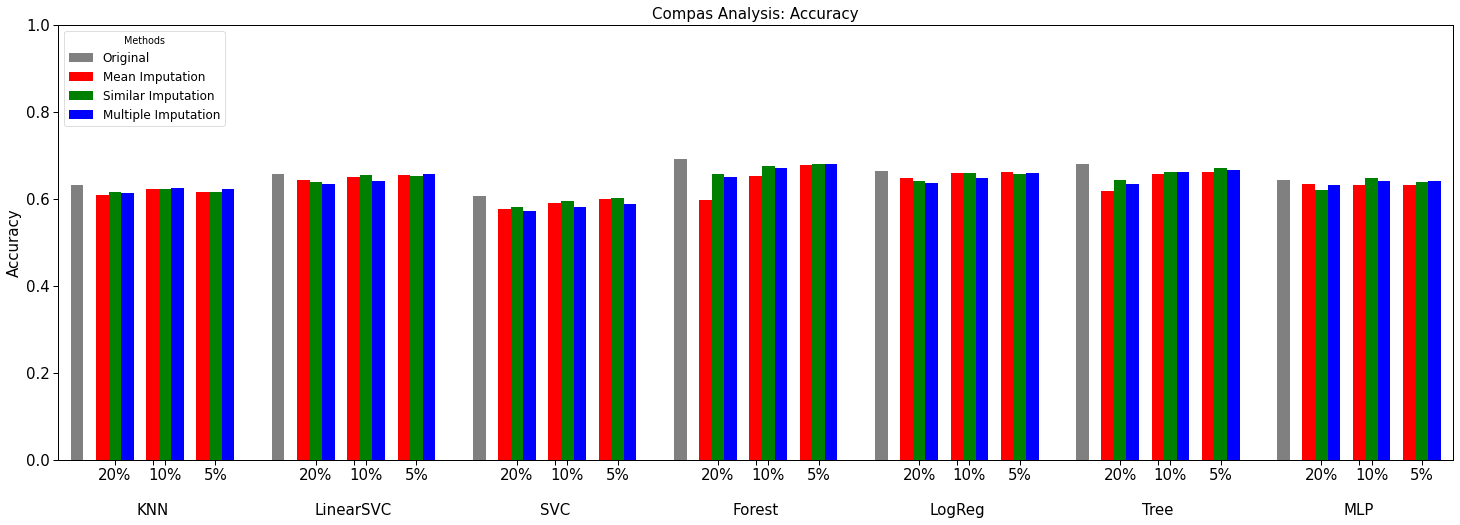

In [112]:
fig = plt.figure(figsize=(25, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=15)
plt.title("Compas Analysis: Accuracy", fontsize=15)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean Imputation", "Similar Imputation", "Multiple Imputation"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
plt.ylabel("Accuracy", fontsize=15)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 1.0])
plt.legend(title="Methods", loc="upper left", prop={"size": 12})
plt.savefig("accuracy.png", transparent=False)
plt.show()